## 无降维
### 没有使用sklearn库，自己手写k-means算法

In [5]:
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def get_distances(X, k, centroids):
    n_samples, n_features = X.shape
    
    distances = np.zeros([X.shape[0], centroids.shape[0]])
    for i, x in enumerate(X):
        for j, centroid in enumerate(centroids):
            b = sum(np.sqrt((x - centroid)**2))
            distances[i][j] = b
    
    return distances

# 定义k-means聚类函数
def k_means(X, k, max_iters, callback=None):
    n_samples, n_features = X.shape
    
    # 随机初始化聚类中心, centroids是聚类中心
    centroids = X[np.random.choice(n_samples, k, replace=False), :]
    
    labels = []

    # 迭代更新聚类中心
    for i in range(max_iters):
        # 计算每个样本到聚类中心的距离
        distances = get_distances(X, k, centroids)

        # 分配每个样本到最近的聚类中心
        # labels存储的是每个样本离的最近的聚类中心的索引
        # labels的索引相当于每个样本的索引
        labels = []
        loss = 0 # 误差
        for i, distance in enumerate(distances):
            d = 0x3f3f3f3f
            index = 0
            for j, dist in enumerate(distance):
                # print("dist ", dist)
                if dist < d:
                    index = j
                    d = dist
            
            # print(d)
            loss += d
            labels.append(index)

        if callback is not None:
            # 通过这个回调函数求每次迭代的时候的损失
            # 直接加上每个样本到他聚类中心的距离
            callback(loss)

        # 更新聚类中心
        centroids = updataCenterIds(X, k, labels, centroids)

    return labels, centroids

def updataCenterIds(X, k, labels, centroids):

    # 这个版本时间复杂度为 O(k*X.shape[0])
    for i in range(k):
        # 存储到这个聚类中心最近的样本
        min_pointer = []
        for j, label in enumerate(labels):
            if label == i:
                min_pointer.append(X[j])
        
        centroids[i] = np.sum(min_pointer, axis=0) / len(min_pointer)

    return centroids



In [39]:
# 读取训练集数据
with open('./MNIST_data/train-images.idx3-ubyte', 'rb') as f:
    train_X = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28*28)

max_iters = 100

k = 10

X = train_X[:2000]

# labels, centroids = k_means(X, k, max_iters)
# print("labels", len(labels))
# print("centroids", centroids)

# print('可视化每个聚类中心')
# plt.style.use({'figure.figsize': (5, 5)})
# col = 4
 
# for i in range(10):
#     print('当前聚类中心：', centroids[i].shape)
#     plt.subplot(3, col, i+1)
#     plt.imshow(centroids[i].reshape(28, 28))
#     plt.xticks([])
#     plt.yticks([])
#     plt.axis('off')
# plt.show()


# 画损失函数
# def callback(loss):
#     losses.append(loss)

# losses = []
# k_means(X, k, max_iters, callback=callback)

# x= np.array(range(len(losses)))

# plt.plot(x, losses)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.show()

### sklearn库的k-means算法

可视化每个聚类中心
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)
当前聚类中心： (784,)


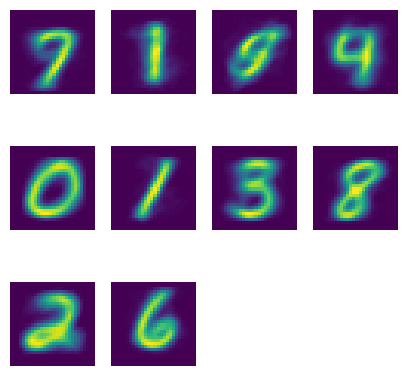

In [41]:
k = 10

kmeans = KMeans(n_clusters=10, random_state=42, max_iter= 50)
kmeans.fit(X)

print('可视化每个聚类中心')
plt.style.use({'figure.figsize': (5, 5)})
col = 4
 
for i in range(k):
    print('当前聚类中心：', kmeans.cluster_centers_[i].shape)
    plt.subplot(3, col, i+1)
    plt.imshow(kmeans.cluster_centers_[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
plt.show()

## 降维之后
### 先计算降到多少维可以保持80%的方差贡献率

#### 数据预处理

In [10]:
#求784维的每一维的均值
xi = train_X.shape[1]
Xmean = np.zeros(xi,dtype="f")#.reshape(xi)
Xstd = np.zeros(xi,dtype="f")
#规范化的样本数据
Strain_X = np.zeros(len(train_X) * xi, dtype="f").reshape(xi, len(train_X))#784*55000

print(Strain_X.shape)

for i in range(xi):#784
    Xmean[i] = np.mean(train_X[:,i]) #求第i维向量的所有数据点的均值
    Xstd[i] = np.std(train_X[:,i], ddof=1) #求第i维向量的所有数据点的标准差

print(len(train_X))

# #规范化所有样本数据
for i in range(len(train_X)):
    for j in range(xi):
        # print(train_X[i][j].T-Xmean[j])
        Strain_X[j][i] = (train_X[i][j].T-Xmean[j])#不归一化
Strain_X

(784, 60000)
60000


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

##### 样本相关矩阵(均值为零，方差不为1) 784*784(协方差矩阵)

In [11]:
R = (1 / len(train_X) - 1) * (np.dot(Strain_X, Strain_X.T))
R

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]], dtype=float32)

##### 奇异值分解求特征值

In [12]:
import math
# 奇异值分解
U,S,VT =np.linalg.svd(R) #VT 的 i 行对应 i 个特征值的特征向量

# 奇异值开根求特征值
S1=np.zeros(len(S)).reshape(len(S),1)
for i in range(len(S)):
    S1[i] = math.sqrt(S[i])
sorted(S1, reverse=True)
S1

array([[1.41289824e+05],
       [1.20816181e+05],
       [1.12649981e+05],
       [1.05291088e+05],
       [1.00076351e+05],
       [9.41828119e+04],
       [8.20394286e+04],
       [7.70212147e+04],
       [7.53762904e+04],
       [6.96306507e+04],
       [6.58685974e+04],
       [6.45085971e+04],
       [5.94095470e+04],
       [5.89976998e+04],
       [5.69852349e+04],
       [5.52311703e+04],
       [5.21983295e+04],
       [5.12505600e+04],
       [4.94190117e+04],
       [4.86940279e+04],
       [4.68309641e+04],
       [4.55065105e+04],
       [4.42891821e+04],
       [4.33258847e+04],
       [4.26285388e+04],
       [4.15512576e+04],
       [4.08839982e+04],
       [4.02191612e+04],
       [3.91400129e+04],
       [3.76977436e+04],
       [3.67929385e+04],
       [3.65138510e+04],
       [3.52079391e+04],
       [3.47364201e+04],
       [3.42425588e+04],
       [3.34403962e+04],
       [3.22555317e+04],
       [3.16787192e+04],
       [3.14692861e+04],
       [3.11683696e+04],


##### 求累计方差贡献率

In [32]:
miuk = 0.8
addS = 0
#记录累加方程贡献率在大于miuk时，有多少个主成分
cnt = 0

for i in range(len(S)):
    addS += S1[i]
    cnt += 1
    if((addS / sum(S1)) >= miuk):
        cnt = i
        break
print(cnt)

# 进行降维
pca =PCA(n_components = cnt + 1)
pca.fit(train_X)
X=pca.transform(train_X)# 降维后的结果
print(X.shape)

238
(60000, 239)


### 通过自己手写的k-means算法进行聚类，并且与没有降维之前作比较

(2000, 239)
labels 2000
centroids [[ 1.12110783e+03 -1.91418567e+02  1.50925865e+02 ... -6.86283399e-02
  -1.48529055e-01 -5.79214673e-01]
 [ 1.08643377e+02  5.31880440e+02 -3.10048778e+02 ... -1.51308960e+00
  -4.96134331e-01  2.21115395e+00]
 [ 5.30202196e+01 -1.83212602e+01  4.76281645e+02 ... -1.27865876e-01
  -2.49151471e+00  1.26519471e+00]
 ...
 [-2.89437371e+02  4.99042709e+02  2.79363506e+02 ...  1.93165664e+00
   2.37979991e-01 -4.88785839e-01]
 [ 1.56585051e+02 -4.65745375e+02 -6.97090082e+01 ... -9.88795082e-01
   3.82694603e-01 -3.17478144e-01]
 [-7.33330060e+02 -4.16226589e+02  4.86420416e+01 ...  4.60949241e-01
   2.30873705e+00 -6.26909767e-01]]
可视化每个聚类中心
当前聚类中心： (239,)
当前聚类中心： (239,)
当前聚类中心： (239,)
当前聚类中心： (239,)
当前聚类中心： (239,)
当前聚类中心： (239,)
当前聚类中心： (239,)


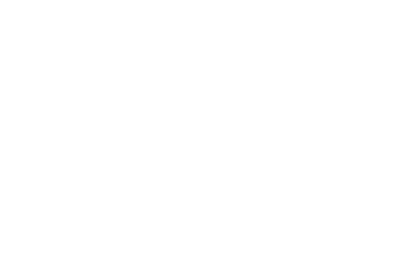

In [35]:
# 原本的60000个样本点太多了，跑不出来，少选几个
X = X[:2000]

print(X.shape)

# labels, centroids = k_means(X, k, max_iters)
# print("labels", len(labels))
# print("centroids", centroids)

# 画损失函数
# def callback(loss):
#     losses.append(loss)

# losses = []
# k_means(X, k, max_iters, callback=callback)

# x= np.array(range(len(losses)))

# plt.plot(x, losses)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.show()

labels, centroids = k_means(X, k, max_iters)
print("labels", len(labels))
print("centroids", centroids)

print('可视化每个聚类中心')
plt.style.use({'figure.figsize': (5, 5)})
col = 4
 
for i in range(k):
    print('当前聚类中心：', centroids[i].shape)
    plt.subplot(3, col, i+1)
    # plt.imshow(centroids[i].reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
plt.show()

### 使用k-means对降维之后的数据进行聚类

In [36]:
kmeans = KMeans(n_clusters=10, random_state=42, max_iter= 50)
kmeans.fit(X)

KMeans(max_iter=50, n_clusters=10, random_state=42)